In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='vAptFCoIjYMUm8Qn58boAvLoWQfD1zTh9kyNA3fXVDx1',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.eu-gb.cloud-object-storage.appdomain.cloud')

bucket = 'nsap-donotdelete-pr-tvrylzfe9cmogl'
object_key = 'nsapallschemes.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head(10)


,finyear,lgdstatecode,statename,lgddistrictcode,districtname,schemecode,totalbeneficiaries,totalmale,totalfemale,totaltransgender,totalsc,totalst,totalgen,totalobc,totalaadhaar,totalmobilenumber
0,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNDPS,108,72,36,0,0,3,104,1,108,69
1,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNOAPS,8438,5059,3379,0,37,235,8083,83,8371,7190
2,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNWPS,202,0,202,0,1,15,180,6,200,159
3,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNDPS,310,211,99,0,0,77,200,33,234,110
4,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNOAPS,5958,3958,2000,0,2,1347,4367,242,3875,2287
5,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNWPS,382,0,382,0,0,65,298,19,260,90
6,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNDPS,95,63,32,0,0,6,81,8,94,93
7,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNOAPS,5021,2911,2110,0,1,197,4443,380,5021,4935
8,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNWPS,304,0,304,0,0,20,260,24,304,258
9,2025-2026,1,JAMMU AND KASHMIR,12,RAJAURI,IGNDPS,78,52,26,0,5,5,68,0,72,3


In [4]:
list(df_1.columns)


['finyear',
 'lgdstatecode',
 'statename',
 'lgddistrictcode',
 'districtname',
 'schemecode',
 'totalbeneficiaries',
 'totalmale',
 'totalfemale',
 'totaltransgender',
 'totalsc',
 'totalst',
 'totalgen',
 'totalobc',
 'totalaadhaar',
 'totalmobilenumber']

In [5]:
from sklearn.preprocessing import LabelEncoder

# Drop unnecessary columns
df_1.drop(['finyear', 'statename', 'districtname'], axis=1, inplace=True)

# Encode target label (schemecode)
le = LabelEncoder()
df_1['schemecode'] = le.fit_transform(df_1['schemecode'])

# Define features and target
X = df_1.drop('schemecode', axis=1)
y = df_1['schemecode']


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

✅ Accuracy: 0.9745370370370371
📄 Classification Report:
               precision    recall  f1-score   support

      IGNDPS       0.96      0.96      0.96       139
     IGNOAPS       0.98      0.96      0.97       151
      IGNWPS       0.99      1.00      0.99       142

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



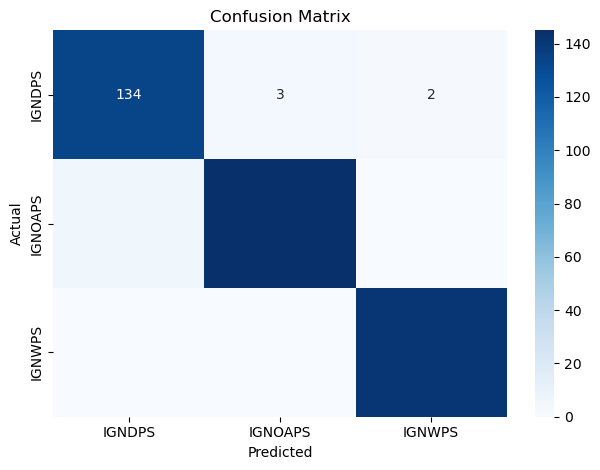

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test)

# Accuracy and report
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📄 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


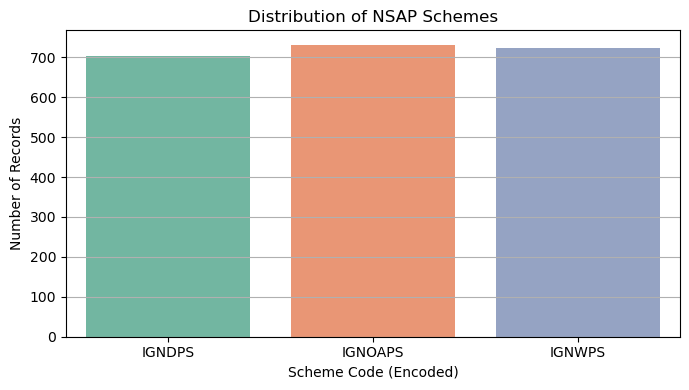

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.countplot(x='schemecode', data=df_1, palette='Set2')
plt.title("Distribution of NSAP Schemes")
plt.xlabel("Scheme Code (Encoded)")
plt.ylabel("Number of Records")
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


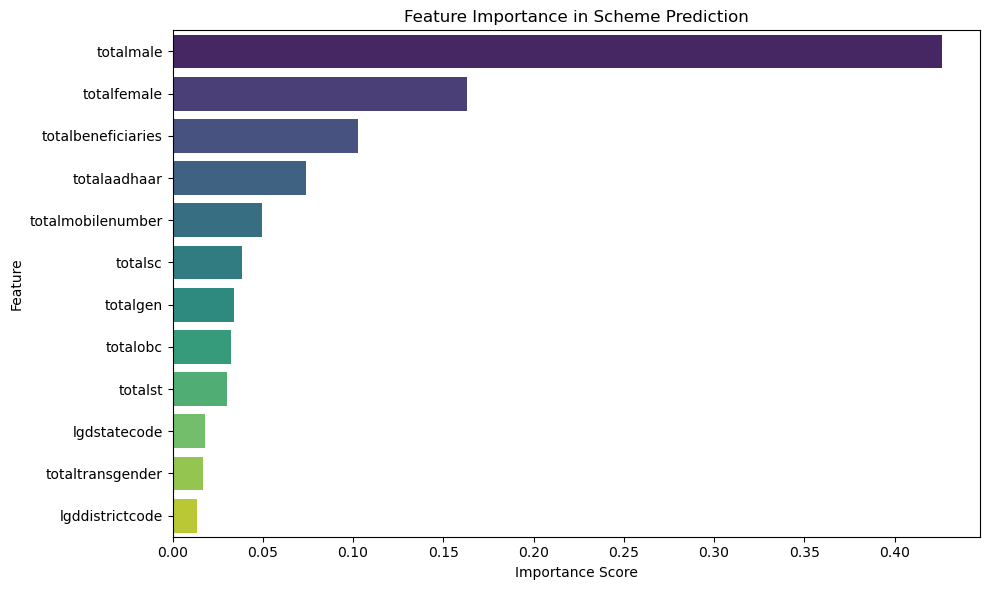

In [9]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="viridis")
plt.title("Feature Importance in Scheme Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


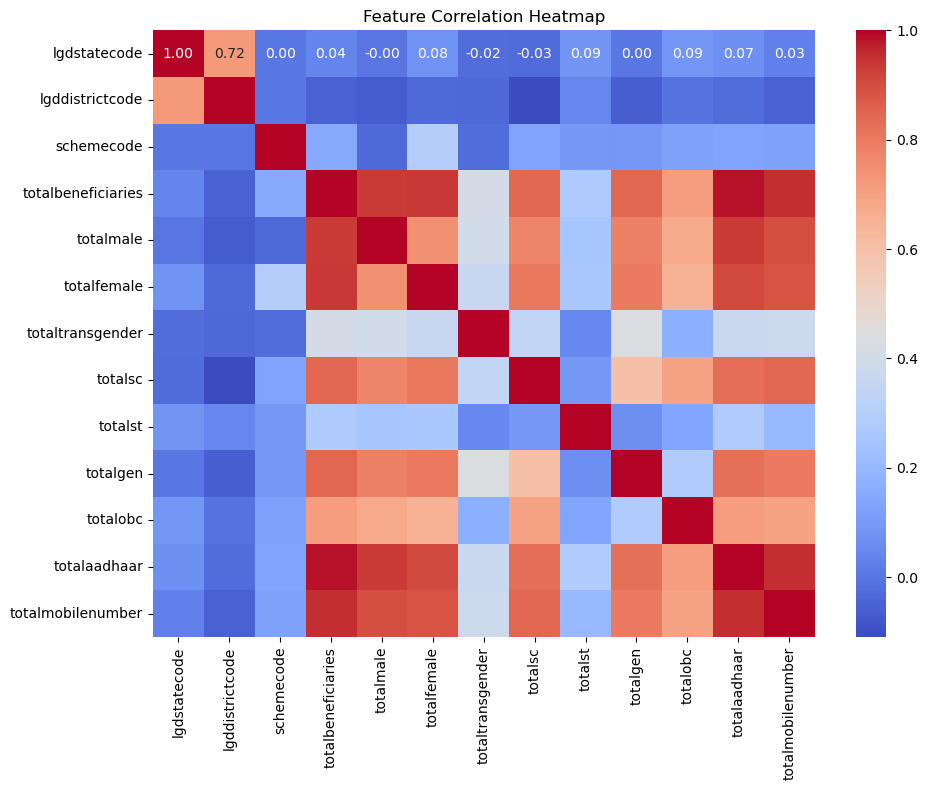

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_1.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


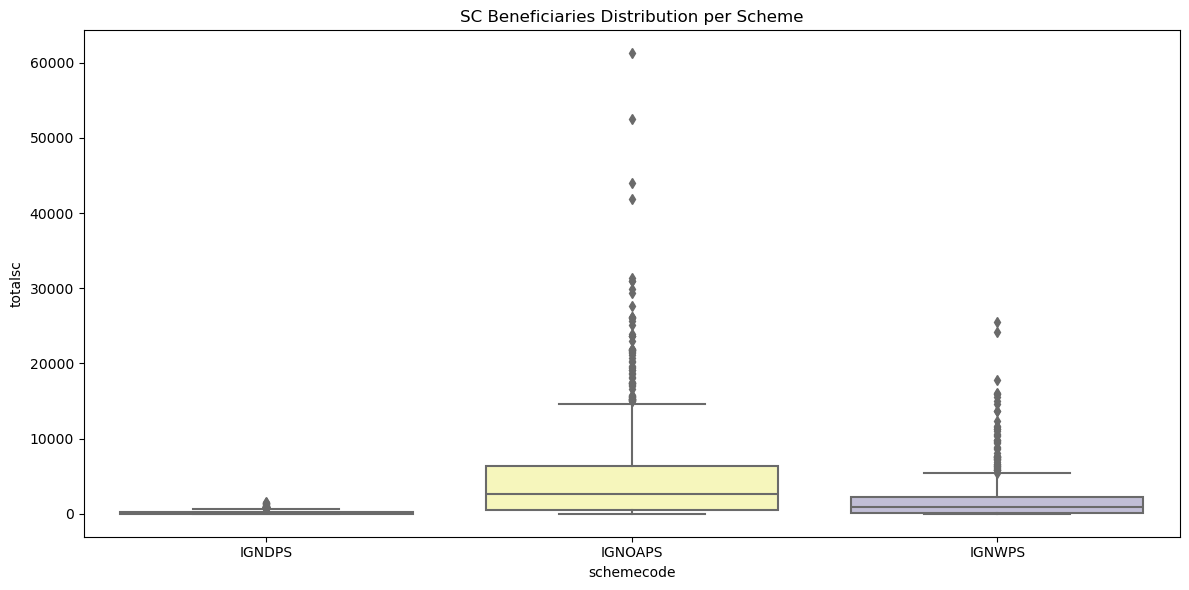

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='schemecode', y='totalsc', data=df_1, palette='Set3')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_)
plt.title("SC Beneficiaries Distribution per Scheme")
plt.tight_layout()
plt.show()


In [8]:
import joblib
joblib.dump(model, "nsap_scheme_model.pkl")


['nsap_scheme_model.pkl']

In [13]:
# Save the cleaned DataFrame as a CSV
df_1.to_csv("cleaned_nsap_for_model.csv", index=False)
print("✅ Cleaned CSV saved as 'cleaned_nsap_for_model.csv'")


✅ Cleaned CSV saved as 'cleaned_nsap_for_model.csv'
